In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
import top_crates
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]

crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
len(selected_builds)

510

Number of crates: 510
has_no_unsafe             259
has_unsafe                251
has_unsafe_blocks         220
has_unsafe_functions      165
has_unsafe_trait_impls     73
has_unsafe_traits          25
dtype: int64
has_no_unsafe             50.784314
has_unsafe                49.215686
has_unsafe_blocks         43.137255
has_unsafe_functions      32.352941
has_unsafe_trait_impls    14.313725
has_unsafe_traits          4.901961
dtype: float64


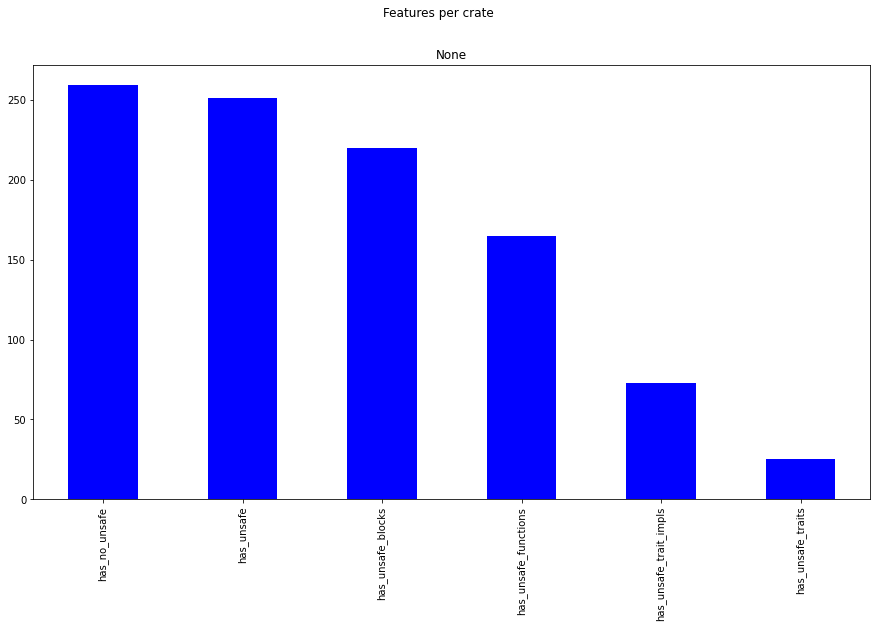

In [5]:
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))
crates["has_unsafe_functions"] = crates[join_key].isin(set(unsafe_function_definitions[join_key].unique()))
crates["has_unsafe_traits"] = crates[join_key].isin(set(unsafe_traits[join_key].unique()))
crates["has_unsafe_trait_impls"] = crates[join_key].isin(set(unsafe_traits_impls[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
    "has_unsafe_functions",
    "has_unsafe_traits",
    "has_unsafe_trait_impls",
]

crates["has_unsafe"] = functools.reduce(lambda x, y: x | y, [crates[f] for f in feature_names])
feature_names.append("has_unsafe")

crates["has_no_unsafe"] = ~crates["has_unsafe"]
feature_names.append("has_no_unsafe")

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
feature_freq.plot.bar(subplots=True, color="blue", title="Features per crate")
print(feature_freq)
print(feature_freq / len(crates) * 100)

In [6]:
print(len(unsafe_blocks))
print(len(user_written_unsafe_blocks))
print(len(unsafe_function_definitions))
print(len(unsafe_traits))
print(len(unsafe_traits_impls))

11333
7331
6353
64
1431


ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64
Unsafe function definitions: 6353


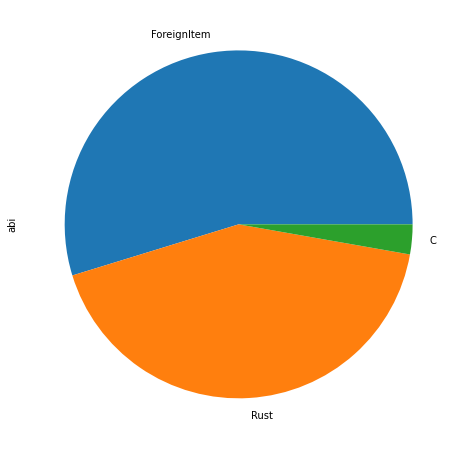

In [7]:
# Frequency of abi
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [8]:
# Which crates call C functions?
c_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'C' in s.abi:
        c_funcs.append(s.crate)

c_funcs = list(dict.fromkeys(c_funcs))

print("Number of crates that call C functions:\t", len(c_funcs))
print("Unique crate names:")

for crate in c_funcs:
    print("\t" + crate)

Number of crates that call C functions:	 7
Unique crate names:
	backtrace
	libc
	wasm_bindgen
	miniz_oxide_c_api
	security_framework
	openssl
	ring


In [9]:
# Which crates call foreign functions?
f_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'ForeignItem' in s.abi:
        f_funcs.append(s.crate)

f_funcs_unique = list(dict.fromkeys(f_funcs))

print("Number of crates that call foreign functions:\t", len(f_funcs_unique))
print("Unique crate names:")

for crate in f_funcs_unique:
    print("\t" + crate)

Number of crates that call foreign functions:	 31
Unique crate names:
	backtrace
	clang_sys
	curl_sys
	openssl_sys
	core_foundation_sys
	inotify_sys
	term_size
	libc
	fuchsia_zircon_sys
	time
	miniz_sys
	libssh2_sys
	libz_sys
	libgit2_sys
	brotli_sys
	cloudabi
	xattr
	termios
	bzip2_sys
	libsqlite3_sys
	security_framework_sys
	backtrace_sys
	errno
	libloading
	crypto
	lzma_sys
	wasi
	fuchsia_cprng
	hermit_abi
	termion
	ring


In [10]:
# SIMD const calls total
const_calls_loaded = utils.load_const_calls()
const_calls_loaded.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
simd_functions = set([
    x
    for x in const_calls_loaded.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(simd_functions)
]

# SIMD const calls unsafe only
unsafe_simd_functions = set([
    x
    for x in unsafe_block_const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
unsafe_simd_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unsafe_simd_functions)
]

# Both should be equal since can only call SIMD in unsafe blocks
assert len(unsafe_simd_calls) == len(simd_calls)

print("Total number of SIMD calls:\t", len(simd_calls))
#simd_calls

Total number of SIMD calls:	 391


In [11]:
# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:\n\t", simd_crates)

Number of crates that call SIMD functions:	 7
Crates that call SIMD functions:
	 ['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']


In [12]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [13]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

all_calls = utils.load_all_calls()

unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [14]:
# Unchecked functions
print("unchecked_function_names:", len(unchecked_function_names))

unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
print("Calls to unchecked functions:", len(unchecked_calls))
print("Percentage:", len(unchecked_calls)/len(unsafe_calls)*100)

values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names: 366
Calls to unchecked functions: 93
Percentage: 0.0967812431706784
Number of crates: 23
Percentage: 4.509803921568627
(json, 79b54c8356a47b67)             14
(http, 6808a9d62e774206)             14
(pest, 90a091c6ae19edc6)              8
(criterion, 8abcfaebda0e558c)         7
(data_encoding, f49ae7fb730d6fb8)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call: 0.7737119970872018


In [15]:
# Unguarded functions
print("unguarded_function_names:", len(unguarded_function_names))

unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
print("Calls to unguarded functions:", len(unguarded_calls))
print("Percentage:", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names: 0
Calls to unguarded functions: 0
Percentage: 0.0
Number of crates: 0
Percentage: 0.0
Series([], dtype: int64)
Percentage of unsafe blocks with an unguarded function call: 0.0


In [16]:
# Pointer operations (not just dereferences)
all_unsafe_function_names = set(unsafe_function_definitions.def_path.unique())
all_safe_function_names = set(function_definitions[function_definitions.unsafety == "Normal"].def_path.unique())
all_closure_names = set(function_definitions[function_definitions.unsafety == "Unknown"].def_path.unique())
assert len(all_unsafe_function_names) > 0
assert len(all_safe_function_names) > 0
assert len(all_closure_names) > 0

print("all_unsafe_function_names:", len(all_unsafe_function_names))
print("all_safe_function_names:", len(all_safe_function_names))
print("all_closure_names:", len(all_closure_names))

count1 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_unsafe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("unsafe functions with a pointer operation:", count1, 100 * count1 / len(all_unsafe_function_names))

count2 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_safe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("safe functions with a pointer operation:", count2, 100 * count2 / len(all_safe_function_names))

count3 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_closure_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("closures with a pointer operation:", count3, 100 * count3 / len(all_closure_names))

all_unsafe_function_names: 6353
all_safe_function_names: 100879
all_closure_names: 12921
unsafe functions with a pointer operation: 0 0.0
safe functions with a pointer operation: 0 0.0
closures with a pointer operation: 0 0.0


In [17]:
# Count functions with pointer operations (another method)
ptr_op_fns = function_unsafe_reasons[function_unsafe_reasons["pointer operation"]]
print("Number of functions using pointer operations:", len(ptr_op_fns))
if len(ptr_op_fns) > 0:
    values = ptr_op_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with pointer operations among 10 top crates:', sum(values[:10])/len(ptr_op_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    ptr_op_fns
    del values

Number of functions using pointer operations: 0


In [18]:
# How many calls to performance-motivated intrinsic functions
blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::intrinsics[0]::[1]::transmute[0]',
        'core[7bab]::intrinsics[0]::write_bytes[0]',
        'core[7bab]::intrinsics[0]::copy[0]',
        'core[7bab]::intrinsics[0]::copy_nonoverlapping[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 469 11333 4.138357010500309

crates 63 12.352941176470589
cgmath                  88
ahash                   65
byteorder               40
wasm_bindgen            21
cast                    20
itoa                    20
crypto                  17
git2                    14
memchr                  12
nix                     11
                        ..
block_padding            1
socket2                  1
scoped_threadpool        1
image                    1
tokio_reactor            1
linked_hash_map          1
signal_hook_registry     1
bumpalo                  1
tokio_current_thread     1
libsqlite3_sys           1
Name: crate_callsite, Length: 63, dtype: int64
26 5.098039215686274

With 1000+ unsafe blocks:


In [19]:
# How many calls to performance-motivated mem functions
blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::mem[0]::transmute_copy[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 8 11333 0.07059031147974941

crates 3 0.5882352941176471
crossbeam_channel     6
ring                  1
const_random_macro    1
Name: crate_callsite, dtype: int64
1 0.19607843137254902

With 1000+ unsafe blocks:


In [20]:
# How many calls to performance-motivated slice functions
blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::slice[0]::from_raw_parts[0]',
        'core[7bab]::slice[0]::from_raw_parts_mut[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 656 11333 5.7884055413394515

crates 71 13.92156862745098
openssl              119
generic_array         73
byteorder             57
ring                  49
rand                  44
nix                   38
git2                  31
encoding_rs           24
image                 13
ahash                 12
                    ... 
rand_xorshift          1
utf8_ranges            1
crossbeam_channel      1
bindgen                1
compiletest_rs         1
sha1                   1
xz2                    1
ryu                    1
wait_timeout           1
tar                    1
Name: crate_callsite, Length: 71, dtype: int64
30 5.882352941176471

With 1000+ unsafe blocks:


In [21]:
user_written_unsafe_block_const_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.check_mode == "UnsafeBlockUserProvided"
]

#user_written_unsafe_block_const_calls_rust = user_written_unsafe_block_const_calls[
#    user_written_unsafe_block_const_calls.abi == "Rust"
#]

perf_mot_unsafe = set([
    x
    for x in user_written_unsafe_block_const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x)
        # ForeignItems and C are included I think
])
perf_mot_unsafe_calls = user_written_unsafe_block_const_calls[
    user_written_unsafe_block_const_calls.def_path.isin(perf_mot_unsafe)
]

print("Total number of performance-motivated calls:\t", len(perf_mot_unsafe_calls))

print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_block_const_calls))

print("Percentage of user-written unsafe block const calls that are performance-motivated:\n\t", 
      (len(perf_mot_unsafe_calls) / len(user_written_unsafe_block_const_calls))*100)

Total number of performance-motivated calls:	 3678
Out of total number user-written unsafe const calls:	 23734
Percentage of user-written unsafe block const calls that are performance-motivated:
	 15.496755709109294


In [22]:
perf_mot_unsafe_calls

,build,package_name,package_version,crate_callsite,build_crate_hash,edition,block,unsafe_scope,check_mode,call,unsafety,abi,build_defsite,package_name_defsite,package_version_defsite,crate_name_defsite,build_crate_hash_defsite,edition_defsite,crate_defsite,crate_hash,def_path,def_path_hash,summary_key,block_defsite,unsafe_scope_defsite,check_mode_defsite,unsafety_defsite,abi_defsite
50,10,object,0.21.1,object,3f7d31cb03159107,2018,34454,18885,UnsafeBlockUserProvided,12349,Unsafe,Rust,10,object,0.21.1,object,3f7d31cb03159107,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::from_raw_parts[0],1b78a877faa9d7f5551fc7063a4eb6f,core.slice.from_raw_parts,34454,18885,UnsafeBlockUserProvided,Unsafe,Rust
52,10,object,0.21.1,object,3f7d31cb03159107,2018,34458,18889,UnsafeBlockUserProvided,12352,Normal,Rust,10,object,0.21.1,object,3f7d31cb03159107,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0],4da4b23c30c15295674344bbcc316c6,core.slice.implement.as_ptr,34458,18889,UnsafeBlockUserProvided,Normal,Rust
54,10,object,0.21.1,object,3f7d31cb03159107,2018,34460,18889,UnsafeBlockUserProvided,12354,Unsafe,Rust,10,object,0.21.1,object,3f7d31cb03159107,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::from_raw_parts[0],1b78a877faa9d7f5551fc7063a4eb6f,core.slice.from_raw_parts,34460,18889,UnsafeBlockUserProvided,Unsafe,Rust
80,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,46484,32738,UnsafeBlockUserProvided,16920,Unsafe,Rust,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::from_raw_parts[0],1b78a877faa9d7f5551fc7063a4eb6f,core.slice.from_raw_parts,46484,32738,UnsafeBlockUserProvided,Unsafe,Rust
88,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,46614,32800,UnsafeBlockUserProvided,16984,Unsafe,rust-intrinsic,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,core,315ae723559ff6e7,core[7bab]::intrinsics[0]::[1]::transmute[0],1ffbbc92ff927f413019f4ddf2b85863,core.intrinsics._1.transmute,46614,32800,UnsafeBlockUserProvided,Unsafe,rust-intrinsic
90,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,47009,32981,UnsafeBlockUserProvided,17171,Unsafe,rust-intrinsic,11,backtrace,0.3.53,backtrace,75be4f73c27229b0,2018,core,315ae723559ff6e7,core[7bab]::intrinsics[0]::[1]::transmute[0],1ffbbc92ff927f413019f4ddf2b85863,core.intrinsics._1.transmute,47009,32981,UnsafeBlockUserProvided,Unsafe,rust-intrinsic
145,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,54634,39028,UnsafeBlockUserProvided,19529,Unsafe,Rust,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::from_raw_parts[0],1b78a877faa9d7f5551fc7063a4eb6f,core.slice.from_raw_parts,54634,39028,UnsafeBlockUserProvided,Unsafe,Rust
147,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,54637,39031,UnsafeBlockUserProvided,19531,Unsafe,Rust,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,core,315ae723559ff6e7,core[7bab]::slice[0]::from_raw_parts_mut[0],559ed87939c95edb44cfd3769fd86bbb,core.slice.from_raw_parts_mut,54637,39031,UnsafeBlockUserProvided,Unsafe,Rust
228,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,68220,45902,UnsafeBlockUserProvided,24762,Unsafe,rust-intrinsic,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,core,315ae723559ff6e7,core[7bab]::intrinsics[0]::[1]::transmute[0],1ffbbc92ff927f413019f4ddf2b85863,core.intrinsics._1.transmute,68220,45902,UnsafeBlockUserProvided,Unsafe,rust-intrinsic
229,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,68223,45904,UnsafeBlockUserProvided,24764,Unsafe,rust-intrinsic,12,gimli,0.22.0,gimli,95bf7aff26470b38,2018,core,315ae723559ff6e7,core[7bab]::intrinsics[0]::[1]::transmute[0],1ffbbc92ff927f413019f4ddf2b85863,core.intrinsics._1.transmute,68223,45904,UnsafeBlockUserProvided,Unsafe,rust-intrinsic


In [23]:
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
]

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
print(feature_freq)
print(feature_freq / len(crates) * 100)

Number of crates: 510
has_unsafe_blocks    220
dtype: int64
has_unsafe_blocks    43.137255
dtype: float64


In [24]:
#unsafe_function_definitions

In [25]:
unsafe_rust_functions = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]
actually_unsafe_rust_functions = unsafe_rust_functions[
    unsafe_rust_functions.uses_unsafe == True
]

print("Number of actually unsafe Rust functions:\t", len(actually_unsafe_rust_functions))
#actually_unsafe_rust_functions

Number of actually unsafe Rust functions:	 1349
